In [ ]:
# Cell 1: Install & Mount Drive
!pip install -q lightgbm scikit-learn pandas numpy matplotlib seaborn

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cell 2: Load Data
import pandas as pd

file_path = "//content/drive/MyDrive/ML_Lab project/flood.csv"
df = pd.read_csv(file_path)

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (50000, 21)


,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,3,8,6,6,4,4,6,2,3,2,...,10,7,4,2,3,4,3,2,6,0.450
1,8,4,5,7,7,9,1,5,5,4,...,9,2,6,2,1,1,9,1,3,0.475
2,3,10,4,1,7,5,4,7,4,9,...,7,4,4,8,6,1,8,3,6,0.515
3,4,4,2,7,3,4,1,4,6,4,...,4,2,6,6,8,8,6,6,10,0.520
4,3,7,5,2,5,8,5,2,7,5,...,7,6,5,3,3,4,4,3,4,0.475


In [ ]:
# Cell 3: Create Binary Target + Clean Split (NO SMOTE!)
df['target'] = (df['FloodProbability'] > 0.5).astype(int)

X = df.drop(['FloodProbability', 'target'], axis=1)
y = df['target']

print("Class distribution (natural):")
print(y.value_counts(normalize=True))

from sklearn.model_selection import train_test_split

# 70% Train — 10% Val — 20% Test (clean split)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.6667, random_state=42, stratify=y_temp
)

print(f"Train: {X_train.shape} | Val: {X_val.shape} | Test: {X_test.shape}")

Class distribution (natural):
target
0    0.5301
1    0.4699
Name: proportion, dtype: float64
Train: (35000, 20) | Val: (4999, 20) | Test: (10001, 20)


In [ ]:
# Cell 4: LightGBM + Random Forest Ensemble (with built-in class weighting)
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

# LightGBM with scale_pos_weight (handles imbalance perfectly)
neg, pos = y_train.value_counts()
scale_pos_weight = neg / pos

lgb_model = lgb.LGBMClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=9,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=scale_pos_weight,   # This replaces SMOTE!
    verbosity=-1
)

# Random Forest with class_weight='balanced'
rf_model = RandomForestClassifier(
    n_estimators=600,
    max_depth=12,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',   # Auto-upweights minority class
    random_state=42,
    n_jobs=-1
)

# Soft Voting Ensemble
ensemble = VotingClassifier(
    estimators=[
        ('lgb', lgb_model),
        ('rf', rf_model)
    ],
    voting='soft'
)

print("Training ensemble (no SMOTE, using class weights only)...")
ensemble.fit(X_train, y_train)

Training ensemble (no SMOTE, using class weights only)...


VotingClassifier(estimators=[('lgb',
                              LGBMClassifier(colsample_bytree=0.8,
                                             learning_rate=0.05, max_depth=9,
                                             n_estimators=600, random_state=42,
                                             scale_pos_weight=1.1280476682677691,
                                             subsample=0.8, verbosity=-1)),
                             ('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=12,
                                                     min_samples_leaf=5,
                                                     min_samples_split=10,
                                                     n_estimators=600,
                                                     n_jobs=-1,
                                                     random_state=42))],
                 voting='soft')

In [ ]:
# Cell 5: Validation Results
y_val_pred = ensemble.predict(X_val)

print("=== VALIDATION PERFORMANCE ===")
print(f"Accuracy : {accuracy_score(y_val, y_val_pred):.5f}")
print(f"F1-Score : {f1_score(y_val, y_val_pred):.5f}")
print(classification_report(y_val, y_val_pred))

=== VALIDATION PERFORMANCE ===
Accuracy : 0.94459
F1-Score : 0.94120
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2650
           1       0.94      0.94      0.94      2349

    accuracy                           0.94      4999
   macro avg       0.94      0.94      0.94      4999
weighted avg       0.94      0.94      0.94      4999



=== FINAL TEST PERFORMANCE (NO SMOTE) ===
Accuracy  : 0.94691
Precision : 0.94702
Recall    : 0.93956
F1-Score  : 0.94328


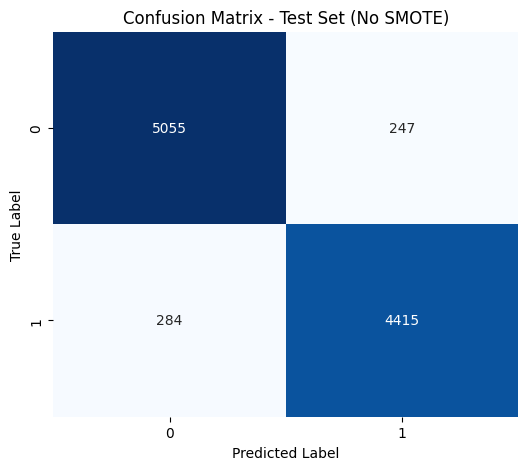

In [ ]:
# Cell 6: FINAL TEST RESULTS (Real Unseen Data)
y_pred = ensemble.predict(X_test)
y_proba = ensemble.predict_proba(X_test)[:, 1]

print("=== FINAL TEST PERFORMANCE (NO SMOTE) ===")
print(f"Accuracy  : {accuracy_score(y_test, y_pred):.5f}")
print(f"Precision : {precision_score(y_test, y_pred):.5f}")
print(f"Recall    : {recall_score(y_test, y_pred):.5f}")
print(f"F1-Score  : {f1_score(y_test, y_pred):.5f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Test Set (No SMOTE)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

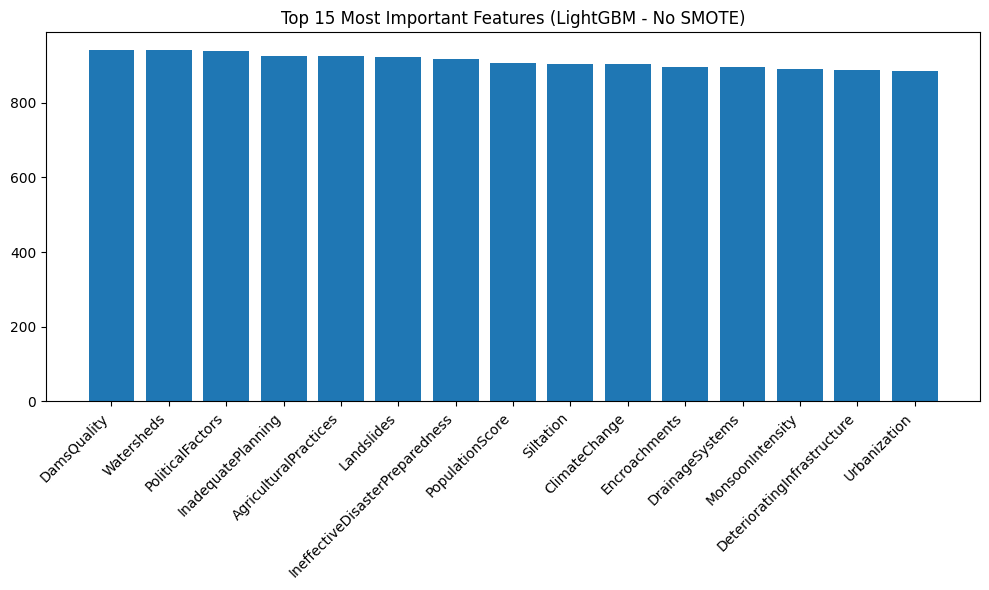

In [ ]:
# Cell 7: Feature Importance (LightGBM)
lgb_model.fit(X_train, y_train)

importances = lgb_model.feature_importances_
feat_names = X.columns
indices = importances.argsort()[::-1]

plt.figure(figsize=(10,6))
plt.title("Top 15 Most Important Features (LightGBM - No SMOTE)")
plt.bar(range(15), importances[indices[:15]])
plt.xticks(range(15), [feat_names[i] for i in indices[:15]], rotation=45, ha='right')
plt.tight_layout()
plt.show()